# Explore collection objects over time

In this notebook we'll explore the temporal dimensions of the `object` data. When were objects created, collected, or used? To do that we'll extract the nested temporal data, see what's there, and create a few charts.

[See here](exploring_object_records.ipynb) for an introduction to the `object` data, and [here to explore places](explore_objects_and_places.ipynb) associated with objects.

If you haven't already, you'll either need to [harvest the `object` data](harvest_records.ipynb), or [unzip a pre-harvested dataset](unzip_preharvested_data.ipynb).

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them.</li>
        <li>To run a code cell click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>

<p><b>Is this thing on?</b> If you can't edit or run any of the code cells, you might be viewing a static (read only) version of this notebook. Click here to <a href="https://mybinder.org/v2/gh/GLAM-Workbench/national-museum-australia/master?urlpath=lab%2Ftree%2Fexplore_collection_object_over_time.ipynb">load a <b>live</b> version</a> running on Binder.</p>

</div>

## Import what we need

In [1]:
import pandas as pd
from ipyleaflet import Map, Marker, Popup, MarkerCluster
import ipywidgets as widgets
from tinydb import TinyDB, Query
from pandas.io.json import json_normalize
import altair as alt
from IPython.display import display, HTML, FileLink
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
# Are you using JupyterLab or the classic Jupyter notebook?
# If you're using the classic notebook, uncomment the following line to make sure Altair charts appear as expected!

# alt.renderers.enable('notebook')

## Load the harvested data

In [28]:
# Load JSON data from file
db = TinyDB('nma_object_db.json')
records = db.all()
Object = Query()

In [29]:
# Convert to a dataframe
df = pd.DataFrame(records)

## Extract the nested events data

Events are linked to objects through the `temporal` field. This field contains nested data that we need to extract and flatten so we can work with it easily. We'll use `json_normalize` to extract the nested data and save each event to a new row.

In [30]:
# Use json_normalise() to explode the temporal into multiple rows and columns
# Then merge the exploded rows back with the original dataset using the id value
# df_dates = pd.merge(df.loc[df['temporal'].notnull()], json_normalize(df.loc[df['temporal'].notnull()].to_dict('records'), record_path='temporal', meta=['id'], record_prefix='temporal_'), how='inner', on='id')
df_dates = json_normalize(df.loc[df['temporal'].notnull()].to_dict('records'), record_path='temporal', meta=['id', 'title', 'additionalType'], record_prefix='temporal_')
df_dates.head()

,temporal_type,temporal_title,temporal_startDate,temporal_endDate,temporal_interactionType,temporal_roleName,temporal_description,id,title,additionalType
0,Event,21 February 2009,2009-02-21,2009-02-21,Production,NaN,NaN,195843,Reproduction cartoon titled 'Better than the b...,[Cartoons]
1,Event,June 1908,1908-06,1908-06,NaN,Date of use,NaN,31257,Kind Regards From Newtown,[Postcards]
2,Event,26 January 1982,1982-01-26,1982-01-26,NaN,Associated date,NaN,135579,Protests during the campaign to save the Frank...,[Photographs]
3,Event,1926,1926,1926,NaN,Date acquired by donor,by Australian Institute of Anatomy,6840,Spinning top,[Centre of gravity toys]
4,Event,1872,1872,1872,NaN,Associated date,NaN,251967,Financial document from Tirranna Picnic Race C...,[Financial records]


Now instead of having one row for each object, we have one row for each object event.

How many date records do we have?

In [6]:
df_dates.shape

(38966, 10)

## Exploring events

Let's extract years from the dates to make comparisons a bit easier.

In [7]:
# Use a regular expression to find the first four digits in the date fields
df_dates['start_year'] = df_dates['temporal_startDate'].str.extract(r'^(\d{4})').fillna(0).astype('int')
df_dates['end_year'] = df_dates['temporal_endDate'].str.extract(r'^(\d{4})').fillna(0).astype('int')

What's the earliest `start_year` (greater than 0)?

In [8]:
df_dates.loc[df_dates['start_year'] > 0]['start_year'].min()

1540

What is it?

In [9]:
earliest = df_dates.loc[df_dates.loc[df_dates['start_year'] > 0]['start_year'].idxmin()]
display(HTML('<a href="http://collectionsearch.nma.gov.au/?object={}">{}</a>'.format(earliest['id'], earliest['title'])))

What's the latest end date?

In [10]:
df_dates['end_year'].max()

2992

Oh, that doesn't look quite right! Let's look to see how many of the dates are in the future!

In [11]:
df_dates.loc[(df_dates['start_year'] > 2019) | (df_dates['end_year'] > 2019)]

,temporal_type,temporal_title,temporal_startDate,temporal_endDate,temporal_interactionType,temporal_roleName,temporal_description,id,title,additionalType,start_year,end_year
10141,Event,17 September 2082,2082-09-17,2082-09-17,Production,NaN,NaN,213266,"Courtroom sketch 'NT Ranger, Mr. Roth.' by Ver...",[Courtroom drawings],2082,2082
19701,Event,7 January 2085,2085-01-07,2085-01-07,Production,NaN,NaN,195336,Woven basket with feathers and ochre,[Baskets],2085,2085
23348,Event,20 March 2085,2085-03-20,2085-03-20,Production,NaN,NaN,146492,Feathered stick with handle,[Ornaments],2085,2085
30479,Event,12 December 2992,2992-12-12,2992-12-12,NaN,Associated date,NaN,67099,Souvenir beaker - Princess Anne,[Commemorative mugs],2992,2992


Looks like these records need some editing.

## Types of events

Events are linked to objects in many different ways, they might document when the object was created, collected, or acquired by the museum. We can examine the types of relationships that have been documented between events and objects by looking in the `temporal_roleName` field.

In [12]:
df_dates['temporal_roleName'].value_counts()

Date of publication       5014
Associated date           4001
Date made                 3908
Date of event             2988
Associated period         2967
Date of voyage            2477
Date collected            2428
Date photographed         1976
Period of use             1706
Date created              1473
Date of production        1012
Date of use                938
Date of issue              858
Date acquired by donor     542
Date acquired by NMA       453
Date written               399
Date of work               346
Date compiled              201
Date worn                  194
Date drawn                 160
Date of Event              139
Date acquired              129
Content created            120
Date of purchase            78
Date posted                 76
Date awarded                75
Date printed                68
Date presented              66
Production date             57
Date designed               47
Date of death               24
Date painted                20
Date of 

Hmmm, you can see that data entry into this field wasn't closely controlled – there are a number of minor variations in capitalisation, format and word order. For example, we have: 'Date of production', 'Date of Production', 'Production date', and 'date of production'!

Some normalisation has taken place though, because of the creation and production related events can be identified through the `temporal_interactionType` field. What sorts of values does it contain?

In [13]:
df_dates['temporal_interactionType'].value_counts()

Production    17870
Name: temporal_interactionType, dtype: int64

There's only one value – 'Production'. According to the [documentation](https://github.com/NationalMuseumAustralia/Collection-API/wiki/Searching-the-API#retrieving-objects-by-date-place-or-party), a value of 'Production' in `interactionType` indicates the event was related to the creation of the item. Let's look to see which of the values in `roleName` have been aggregated by the 'Production' value.

In [14]:
df_dates.loc[(df_dates['temporal_interactionType'] == 'Production')]['temporal_roleName'].value_counts()

Date of publication       5009
Date made                 3908
Date photographed         1758
Date created              1473
Date of production        1012
Date of issue              675
Date written               399
Date of work               321
Date compiled              201
Date drawn                 160
Content created            120
Date posted                 76
Date printed                68
Production date             57
Date designed               47
Date painted                20
Date of restoration         18
Date of conversion          14
Date reprinted              12
Date of correspondence      10
Date of patent               9
Date of Publication          7
date created                 6
date of publication          5
Date of Production           4
date of production           2
Date of Correspondence       2
Date of Work                 1
Date repographed             1
Date reproduced              1
date of correspondence       1
date painted                 1
date mad

So the `temporal_interactionType` field helps us find all the creation-related events without dealing with the variations in the ways event types are described. Yay for normalisation!

## Creation dates

Let's create a dataframe that contains just the creation dates.

In [15]:
df_creation_dates = df_dates.loc[(df_dates['temporal_interactionType'] == 'Production')].copy()

In [16]:
df_creation_dates.shape

(17870, 12)

One other thing to note is that not every event has a start date. Some just have an end date. To make sure we have at least one date for every event, let's create a new `year` column – we'll set its value to `start_year` if it exists, or `end_year` if not.

In [17]:
df_creation_dates['year'] = df_creation_dates.apply(lambda x: x['start_year'] if x['start_year'] else x['end_year'], axis=1)

Time to make a chart! Let's show how the creation events are distributed over time.

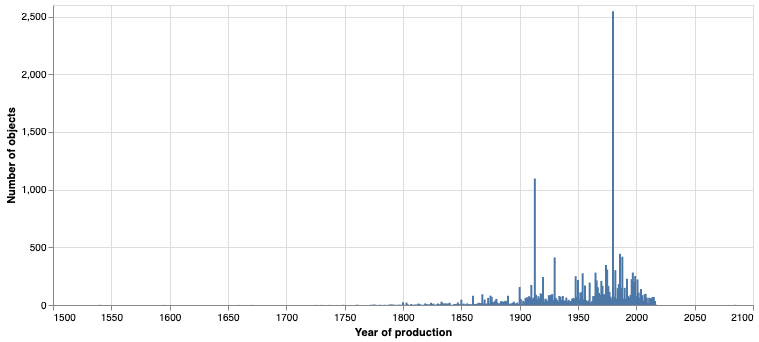

In [18]:
# Create a bar chart (limit to years greater than 0)
alt.Chart(df_creation_dates.loc[df_creation_dates['year'] > 0]).mark_bar(size=2).encode(
    
    # Year on the X axis
    x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year of production')),
    
    # Number of objects on the Y axis
    y=alt.Y('count()', title='Number of objects'),
    
    # Show details on hover
    tooltip=[alt.Tooltip('year:Q', title='Year'), alt.Tooltip('count():Q', title='Objects', format=',')]
).properties(width=700)

Ok, so something interesting was happening in 1980 and 1913. Let's see if we can find out what.

In another notebook I showed how you can [use the `additionalType` column](exploring_object_records.ipynb#The-additionalType-field) to find out about the types of things in the collection. Let's use it to see what types of objects were created in 1980.

Let's explode `additionalType` and create a new dataframe with the results!

In [19]:
df_creation_dates_types = df_creation_dates.loc[df_creation_dates['additionalType'].notnull()][['id', 'title', 'year', 'additionalType']].explode('additionalType')
df_creation_dates_types.head()

,id,title,year,additionalType
0,195843,Reproduction cartoon titled 'Better than the b...,2009,Cartoons
5,59924,Walka design from Ernabella,1954,Acrylic paintings
8,33064,"Wonderland city, Sydney",1906,Photographic postcards
10,19877,Cylindrical hollow wood pipe with protruding bowl,1973,Smoking pipes
12,124027,Oak oil stone,1790,Sharpening stones


Now we can filter by year to see what types of things were created in 1980.

In [20]:
created_1980 = df_creation_dates_types.loc[df_creation_dates_types['year'] == 1980]
created_1980.head()

,id,title,year,additionalType
16,166857,Spergularia media,1980,Mounts
30,166711,Ipomea aquatica Convolvulaceae,1980,Engravings
52,166367,Persoonia levis,1980,Engravings
91,166221,Centranthera cochinchinensis,1980,Engravings
102,165539,Triumfetta repens,1980,Engravings


Let's look at the top twenty types of things created in 1980!

In [21]:
created_1980['additionalType'].value_counts()[:20]

Engravings             1486
Mounts                  743
Folders                 100
Lists                    42
Notes                    36
Boxes                    35
Technical notes          34
Paintings                 5
Cartoons                  5
Placards                  3
Journals                  3
Storybooks                2
Advertising posters       2
Botanical drawings        2
Books                     2
Jugs                      2
Passes                    2
Textbooks                 2
Squares                   1
Medallions                1
Name: additionalType, dtype: int64

So the vast majority are either 'Engravings' or 'Mounts'. Let's look at one of the 'Engravings' in more detail.

In [22]:
# Filter by Engravings
created_1980.loc[created_1980['additionalType'] == 'Engravings'].head()

,id,title,year,additionalType
30,166711,Ipomea aquatica Convolvulaceae,1980,Engravings
52,166367,Persoonia levis,1980,Engravings
91,166221,Centranthera cochinchinensis,1980,Engravings
102,165539,Triumfetta repens,1980,Engravings
121,167685,Lecanthus solandri,1980,Engravings


In [23]:
# Get the first item
item = created_1980.loc[created_1980['additionalType'] == 'Engravings'].iloc[0]

# Create a link to the collection db
display(HTML('<a href="http://collectionsearch.nma.gov.au/?object={}">{}</a>'.format(item['id'], item['title'])))

If you follow the link you'll find that the engravings were created for a new publication of Banks' *Florilegium*.

Can you repeat this process to find out what happened in 1913?

## Creation dates by object type

Now that we have a dataframe that combines creation dates with object types, we can look at how the creation of particular object types changes over time. For example let's look at 'Photographs' and 'Postcards'.

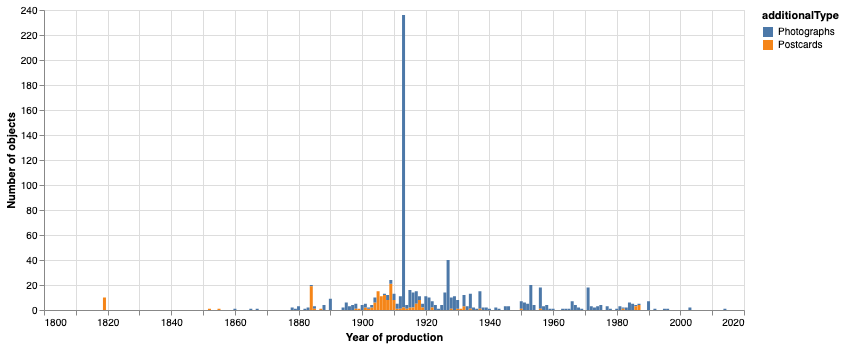

In [24]:
# Create a dataframe containing just Photographs and Postcards -- use .isin() to filter the additionalType field
df_photos_postcards = df_creation_dates_types.loc[(df_creation_dates_types['year'] > 0) & (df_creation_dates_types['additionalType'].isin(['Photographs', 'Postcards']))]

# Create a stacked bar chart
alt.Chart(df_photos_postcards).mark_bar(size=3).encode(
    
    # Year on the X axis
    x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year of production')),
    
    # Number of objects on the Y axis
    y=alt.Y('count()', title='Number of objects'),
    
    # Color according to the type
    color='additionalType:N',
    
    # Details on hover
    tooltip=[alt.Tooltip('additionalType:N', title='Type'), alt.Tooltip('year:Q', title='Year'), alt.Tooltip('count():Q', title='Objects', format=',')]
).properties(width=700)

There's 1913 again... It's also interesting to see a shift from postcards to photos in the early decades of the 20th century.

We could add additional types to this chart, but it will get a bit confusing. Let's try another way of charting changes in the creation of the most common object types over time.

First we'll get the top twenty-five object types (which have creation dates) as a list.

In [25]:
# Get most common 25 values and convert to a list
top_types = df_creation_dates_types['additionalType'].value_counts()[:25].index.to_list()
top_types

['Engravings',
 'Bark paintings',
 'Cartoons',
 'Negatives',
 'Mounts',
 'Photographs',
 'Paintings',
 'Drawings',
 'Prints',
 'Acrylic paintings',
 'Letters',
 'Photographic postcards',
 'Books',
 'Photographic slides',
 'Courtroom drawings',
 'Glass plate negatives',
 'Postcards',
 'Cards',
 'Botanical specimens',
 'Prize certificates',
 'Collecting cards',
 'Sculptures',
 'Telegrams',
 'Portrait photographs',
 'Posters']

Now we'll use the list of `top_types` to filter the creation dates, so we only have events relating to those types og objects.

In [26]:
# Only include records where the additionalType value is in the list of top_types
df_top_types = df_creation_dates_types.loc[(df_creation_dates_types['year'] > 0) & (df_creation_dates_types['additionalType'].isin(top_types))]

To chart this data we're going to use circles for each point and create 'bubble lines' for each object type to show how the number of objects created varied year by year.

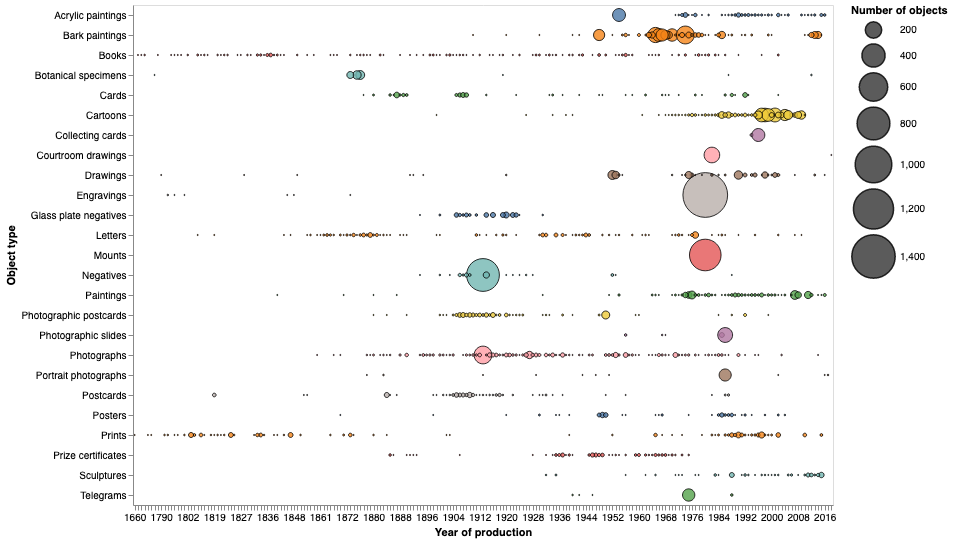

In [27]:
# Create a chart
alt.Chart(df_top_types).mark_circle(
    
    # Style the circles
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    
    # Year on the X axis
    x=alt.X('year:O', axis=alt.Axis(format='c', title='Year of production', labelAngle=0)),
    
    # Object type on the Y axis
    y=alt.Y('additionalType:N', title='Object type'),
    
    # Size of the circles represents the number of objects
    size=alt.Size('count():Q',
        scale=alt.Scale(range=[0, 2000]),
        legend=alt.Legend(title='Number of objects')
    ),
    
    # Color the circles by object type
    color=alt.Color('additionalType:N', legend=None),
    
    # More details on hover
    tooltip=[alt.Tooltip('additionalType:N', title='Type'), alt.Tooltip('year:O', title='Year'), alt.Tooltip('count():Q', title='Objects', format=',')]
).properties(
    width=700
)

What patterns can you see? Hover over the cricles for more information. Once again the engravings dominate, but also look at the bark paintings and cartoons, what might be happening there?

----

Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.github.io/).

Work on this notebook was supported by the [Humanities, Arts and Social Sciences (HASS) Data Enhanced Virtual Lab](https://tinker.edu.au/).